In [1]:
!pip install Qiskit
!pip install qiskit-ibm-runtime
!pip install numpy
!pip install qiskit-aer matplotlib
!pip install networkx
!pip install qiskit-aer qiskit-optimization scipy

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler



service = QiskitRuntimeService.save_account( 
 token="BuF7MWIBzFCA2QfjVi9KXhbND8U9HwwqT07AR1ydJPdQ", 
 instance="crn:v1:bluemix:public:quantum-computing:us-east:a/624a449c58db4cebbbcd6d44cd96889e:349d8595-be2d-464a-aea1-6494895ebe55::", 
 name="EunsuLEE", 
 overwrite=True
 )

C:\Users\leeun\AppData\Local\Temp\ipykernel_23796\910762644.py:122: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(num_qubits=4, inverse=True, do_swaps=True), [0, 1, 2, 3])
C:\Users\leeun\AppData\Local\Temp\ipykernel_23796\910762644.py:143: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(num_qubits=4, inverse=False, do_swaps=True), [0, 1, 2, 3])


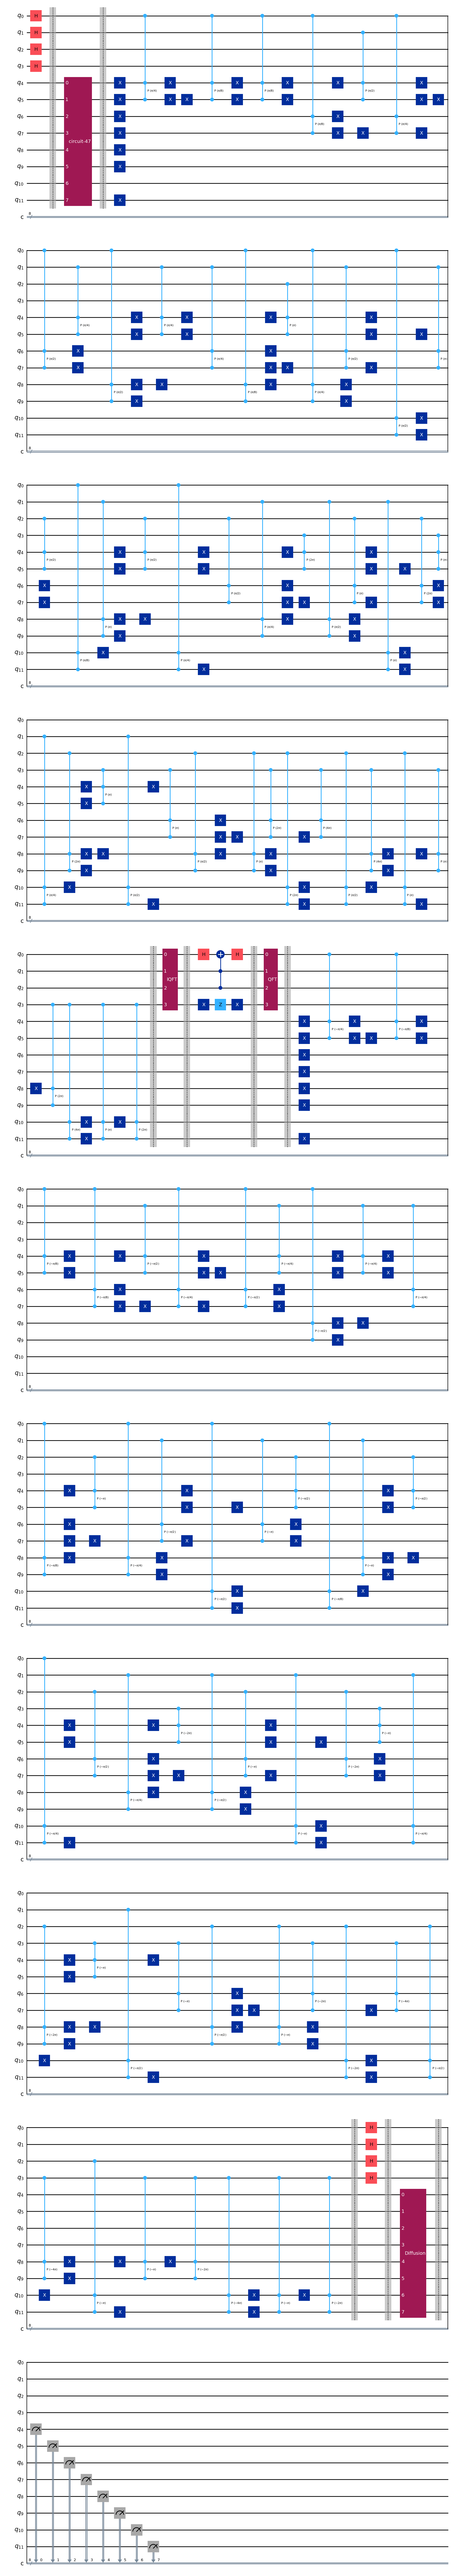

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT, StatePreparation
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

# 회로 초기화
qc = QuantumCircuit(12, 8)
for i in range(4):
    qc.h(i)

qc.barrier()

# ---------------------------------------------------------
# 1. 상태 준비 (Superposition)
# ---------------------------------------------------------
def create_superposition_circuit(target_states):
    num_qubits = len(target_states[0])
    num_states = len(target_states)
    
    state_vector = np.zeros(2**num_qubits)
    amplitude = 1 / np.sqrt(num_states)
    
    for bitstring in target_states:
        index = int(bitstring, 2)
        state_vector[index] = amplitude
        
    temp_qc = QuantumCircuit(num_qubits)
    temp_qc.append(StatePreparation(state_vector), range(num_qubits))
    
    # 기본 게이트로 변환 (u, cx)
    decomposed_qc = transpile(temp_qc, basis_gates=['u', 'cx'])
    
    return decomposed_qc

target_bitstrings = ['11000110', '10001101', '01110010', '10110100', '01101100', '11100001']
U_state = create_superposition_circuit(target_bitstrings)
qc.append(U_state, [4, 5, 6, 7, 8, 9, 10, 11])

qc.barrier()

# ---------------------------------------------------------
# 2. Controlled-U 구현 (UnitaryGate 대체)
# ---------------------------------------------------------
# Theta 정의
theta11 = 0
theta12 = np.pi/2
theta13 = np.pi/8
theta14 = np.pi/4
theta21 = theta12
theta22 = 0
theta23 = np.pi/4
theta24 = np.pi/8
theta31 = theta13
theta32 = np.pi/8
theta33 = 0
theta34 = np.pi/8
theta41 = theta14
theta42 = np.pi/4
theta43 = np.pi/2
theta44 = 0

u_thetas = [
    [theta11, theta21, theta31, theta41], # U1
    [theta12, theta22, theta32, theta42], # U2
    [theta13, theta23, theta33, theta43], # U3
    [theta14, theta24, theta34, theta44]  # U4
]
qubit_pairs = [[4, 5], [6, 7], [8, 9], [10, 11]]

def apply_controlled_diagonal_U(circuit, control_qubit, power, inverse):
    """
    Code B(UnitaryGate)와 완벽히 동일한 동작을 하도록 수정한 함수
    1. U 적용 순서 반전 (U4 -> U1)
    2. state_idx 1, 2에 대한 X 게이트 로직 수정 (Endian 교정)
    """
    sign = -1 if inverse else 1
    num_U = len(u_thetas)

    for u_idx, (q1, q2) in enumerate(qubit_pairs):
        # 1. 행렬 순서 반전 (Code B와 일치시키기 위함)
        current_thetas = u_thetas[num_U - 1 - u_idx]
        
        for state_idx, theta in enumerate(current_thetas):
            if theta == 0:
                continue
            
            # 위상 각도 계산
            angle = sign * theta * (2**power)
            
            # |00>, |01>, |10>, |11> 상태에 따라 선택적으로 위상 적용
            # Qiskit Little Endian 기준: [q1, q2] -> q1이 LSB(2^0), q2가 MSB(2^1)
            
            if state_idx == 0:   # Binary 00 (q1=0, q2=0) -> 둘 다 뒤집어야 11됨
                circuit.x([q1, q2])
                circuit.mcp(angle, [control_qubit, q1], q2) 
                circuit.x([q1, q2])
                
            elif state_idx == 1: # Binary 01 -> 실제로는 (q1=1, q2=0) -> q2만 뒤집어야 11됨
                # [수정됨] 기존 x(q1) -> x(q2)
                circuit.x(q2)
                circuit.mcp(angle, [control_qubit, q1], q2)
                circuit.x(q2)
                
            elif state_idx == 2: # Binary 10 -> 실제로는 (q1=0, q2=1) -> q1만 뒤집어야 11됨
                # [수정됨] 기존 x(q2) -> x(q1)
                circuit.x(q1)
                circuit.mcp(angle, [control_qubit, q1], q2)
                circuit.x(q1)
                
            elif state_idx == 3: # Binary 11 (q1=1, q2=1) -> 안 뒤집어도 됨
                circuit.mcp(angle, [control_qubit, q1], q2)

# CU 적용 loop
for i in range(4):
    apply_controlled_diagonal_U(qc, control_qubit=i, power=i, inverse=False)

qc.barrier()

# QFT Inverse
qc.append(QFT(num_qubits=4, inverse=True, do_swaps=True), [0, 1, 2, 3])

qc.barrier()

# ---------------------------------------------------------
# 3. Oracle (첫 번째 코드와 동일하게 수정)
# ---------------------------------------------------------
# 첫 번째 코드의 Oracle: x(3) -> z(3) -> x(3) 그리고 h(0) -> ccx(2,1,0) -> h(0)
# 이 부분은 Code 1과 완전히 동일한 게이트를 사용합니다.

qc.x(3)
qc.z(3)
qc.x(3)

qc.h(0)
qc.ccx(2, 1, 0)
qc.h(0)

qc.barrier()

# QFT
qc.append(QFT(num_qubits=4, inverse=False, do_swaps=True), [0, 1, 2, 3])

qc.barrier()

# ---------------------------------------------------------
# 4. Inverse Controlled-U 구현
# ---------------------------------------------------------
for i in range(4):
    apply_controlled_diagonal_U(qc, control_qubit=i, power=i, inverse=True)

qc.barrier()

for i in range(4):
    qc.h(i)

qc.barrier()

# ---------------------------------------------------------
# 5. Diffusion Operator
# ---------------------------------------------------------
def create_diffusion_circuit(u_state_circuit, num_qubits):
    diffusion_qc = QuantumCircuit(num_qubits, name="Diffusion")
    
    # Inverse U_state
    diffusion_qc.append(u_state_circuit.inverse(), range(num_qubits))
    
    # Reflection
    diffusion_qc.x(range(num_qubits))
    diffusion_qc.h(num_qubits - 1)
    diffusion_qc.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    diffusion_qc.h(num_qubits - 1)
    diffusion_qc.x(range(num_qubits))
    
    # U_state
    diffusion_qc.append(u_state_circuit, range(num_qubits))
    return diffusion_qc

D_circuit = create_diffusion_circuit(U_state, 8)
qc.append(D_circuit,  [4, 5, 6, 7, 8, 9, 10, 11])

qc.barrier()

# 측정
qc.measure([4, 5, 6, 7, 8, 9, 10, 11], [0, 1, 2, 3, 4, 5, 6, 7])

# 시각화
qc.draw("mpl")

In [5]:
print("Simulation started...")
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate, QFT, StatePreparation
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# 1. 시뮬레이터 설정 (AerSimulator 사용)
simulator = AerSimulator()

# 2. 회로 트랜스파일 (시뮬레이터가 이해할 수 있는 게이트로 변환)
# UnitaryGate가 포함되어 있어, 이를 기본 게이트로 분해하는 과정이 필요할 수 있습니다.
qc_transpiled = transpile(qc, simulator, optimization_level=3)

# 3. 시뮬레이션 실행 (shots=1024는 실험 반복 횟수)
job = simulator.run(qc_transpiled, shots=4096)
result = job.result()
print(f"변환 전 깊이: {qc.depth()}")
print(f"변환 후 깊이(물리적 근사): {qc_transpiled.depth()}")
# 4. 결과 가져오기
counts = result.get_counts()
print("\nSimulation Results (Counts):")
print(counts)

# 5. 결과 시각화 (히스토그램)
plot_histogram(counts)
plt.show() # 그래프 출력

Simulation started...
변환 전 깊이: 106
변환 후 깊이(물리적 근사): 1563

Simulation Results (Counts):
{'10110100': 78, '11100001': 3714, '10001101': 73, '11000110': 83, '01110010': 70, '01101100': 78}


In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService(name = "EunsuLEE")

backend = service.backend("ibm_pittsburgh")
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(qc)


management.get:WARNING:2025-12-19 10:39:13,196: Loading saved account: EunsuLEE


In [7]:
estimator = Sampler(mode = backend)
estimator.options.default_shots = 5000
 

# One pub, with one circuit to run against five different observables.
job = estimator.run([isa_circuit])
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
 
# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

NameError: name 'backend' is not defined

In [11]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
 
# 이전에 제출했던 작업의 ID를 변수에 저장합니다.
job_id = "d51t45jht8fs739tdmug" 
service = QiskitRuntimeService(name = "EunsuLEE")
# service.job() 메서드를 사용하여 작업을 불러옵니다.
retrieved_job = service.job(job_id)

job_result = retrieved_job.result()

print(job_result)

counts_int = retrieved_job.result()[0].data.c.get_int_counts()
counts_bin = retrieved_job.result()[0].data.c.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)
# This is the result from our single pub, which had six observables,
# so contains information on all six.

management.get:WARNING:2025-12-19 10:39:31,176: Loading saved account: EunsuLEE


PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=5000, num_bits=8>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-12-19 01:24:40', stop='2025-12-19 01:24:43', size=5000>)])}, 'version': 2})
{215: 0.0018, 201: 0.004, 54: 0.006, 70: 0.0048, 232: 0.0022, 163: 0.005, 62: 0.0036, 106: 0.0036, 8: 0.007, 92: 0.0024, 37: 0.0048, 142: 0.0048, 82: 0.0042, 176: 0.0044, 0: 0.0116, 5: 0.0076, 134: 0.007, 144: 0.0046, 224: 0.0044, 96: 0.0036, 185: 0.0028, 16: 0.0094, 28: 0.003, 193: 0.0036, 212: 0.0022, 195: 0.0038, 248: 0.002, 202: 0.0034, 19: 0.0054, 136: 0.0064, 197: 0.0038, 90: 0.0028, 128: 0.008, 238: 0.0026, 18: 0.0058, 229: 0.0018, 105: 0.002, 57: 0.0036, 14: 0.0052, 208: 0.0048, 141: 0.0054, 132: 0.005, 242: 0.0034, 50: 0.006, 42: 0.0054, 164: 0.0058, 206: 0.0032, 85: 0.005, 31: 0.0036, 135: 0.0034, 60: 0.0038, 38: 0.0068, 149: 0.0032, 6: 0.0094, 17: 0.0074, 131: 0.0052, 87: 0.0018,

In [ ]:
# General
import numpy as np
 
# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(name = "EunsuLEE")

backend = service.backend("ibm_marrakesh")

theta = Parameter("$\\theta$")
 
chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0)
chsh_circuit.cx(0, 1)
chsh_circuit.ry(theta, 0)
chsh_circuit.draw("mpl")


number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

# <CHSH1> = <AB> - <Ab> + <aB> + <ab> -> <ZZ> - <ZX> + <XZ> + <XX>
observable1 = SparsePauliOp.from_list(
    [("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)]
)
 
# <CHSH2> = <AB> + <Ab> - <aB> + <ab> -> <ZZ> + <ZX> - <XZ> + <XX>
observable2 = SparsePauliOp.from_list(
    [("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)]
)

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
chsh_isa_circuit = pm.run(chsh_circuit)
chsh_isa_circuit.draw("mpl")

isa_observable1 = observable1.apply_layout(layout=chsh_isa_circuit.layout)
isa_observable2 = observable2.apply_layout(layout=chsh_isa_circuit.layout)
print(f"변환 후 깊이(물리적 근사): {chsh_isa_circuit.depth()}")
# To run on a local simulator:
# Use the StatevectorEstimator from qiskit.primitives instead.
 
estimator = Estimator(mode=backend)
 
pub = (
    chsh_isa_circuit,  # ISA circuit
    [[isa_observable1], [isa_observable2]],  # ISA Observables
    individual_phases,  # Parameter values
)
 
job_result = estimator.run(pubs=[pub]).result()


chsh1_est = job_result[0].data.evs[0]
chsh2_est = job_result[0].data.evs[1]

fig, ax = plt.subplots(figsize=(10, 6))
 
# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)
 
# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")
 
# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)
 
# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
 
# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()

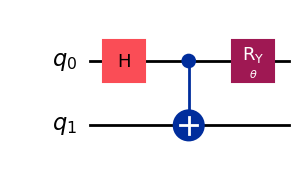

In [5]:
chsh_circuit.draw("mpl")

management.get:WARNING:2025-12-15 12:13:06,872: Loading saved account: EunsuLEE


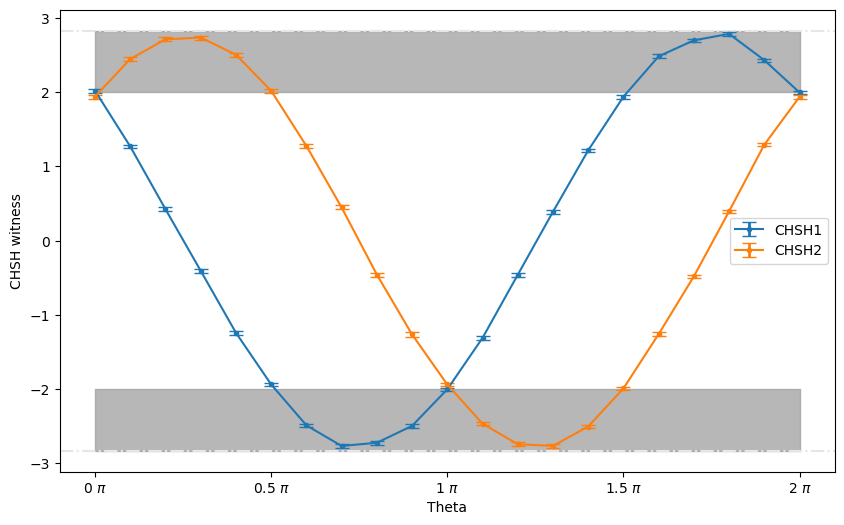

CHSH1 기댓값: [ 2.02033724  1.26966148  0.42476509 -0.40468529 -1.23928434 -1.93538422
 -2.48629167 -2.76431973 -2.72107092 -2.49401467 -2.00128717 -1.30982108
 -0.45926117  0.38975415  1.2166302   1.93898829  2.48371734  2.69893165
  2.78594414  2.43171579  1.99665337]
CHSH2 기댓값: [ 1.94104775  2.44767666  2.71283305  2.73600206  2.50585661  2.01982237
  1.27738448  0.44844896 -0.4556571  -1.26245334 -1.93641395 -2.4641524
 -2.74115073 -2.76329    -2.50276741 -1.98944523 -1.25833441 -0.47985584
  0.39593255  1.29386021  1.93795855]
CHSH1 표준편차: [0.02606166 0.02501901 0.02623357 0.02662135 0.02844299 0.02451061
 0.02381015 0.02626059 0.02652618 0.02951101 0.02422955 0.02435847
 0.02617381 0.02340158 0.02511144 0.02383749 0.0262356  0.02372867
 0.02458202 0.02209633 0.02393847]
CHSH2 표준편차: [0.02606166 0.02501901 0.02623357 0.02662135 0.02844299 0.02451061
 0.02381015 0.02626059 0.02652618 0.02951101 0.02422955 0.02435847
 0.02617381 0.02340158 0.02511144 0.02383749 0.0262356  0.02372867
 0.0

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

service = QiskitRuntimeService(name = "EunsuLEE")
job_id = "d4uh435eastc73ch7bg0" 

# service.job() 메서드를 사용하여 작업을 불러옵니다.
retrieved_job = service.job(job_id)

job_result = retrieved_job.result()
# 1. 기댓값(Expectation Values) 추출
chsh1_est = job_result[0].data.evs[0]
chsh2_est = job_result[0].data.evs[1]

# 2. 표준편차(Standard Deviations) 추출 (EstimatorV2는 stds를 자동 계산하여 반환함)
chsh1_std = job_result[0].data.stds[0]
chsh2_std = job_result[0].data.stds[1]

fig, ax = plt.subplots(figsize=(10, 6))

# 3. 오차 막대(Error Bar)가 포함된 그래프 그리기
# ax.plot 대신 ax.errorbar를 사용합니다.
# yerr: y축 오차(표준편차), capsize: 오차 막대 끝 가로줄 크기, fmt: 마커 및 선 스타일

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
ax.errorbar(phases / np.pi, chsh1_est, yerr=chsh1_std, fmt=".-", label="CHSH1", zorder=3, capsize=5, elinewidth=2)
ax.errorbar(phases / np.pi, chsh2_est, yerr=chsh2_std, fmt=".-", label="CHSH2", zorder=3, capsize=5, elinewidth=2)
# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()
# ... (데이터 추출 부분 아래에 추가)
print("CHSH1 기댓값:", chsh1_est)
print("CHSH2 기댓값:", chsh2_est)
print("CHSH1 표준편차:", chsh1_std)
print("CHSH2 표준편차:", chsh2_std)

# 만약 [0.015, 0.014, ...] 처럼 숫자가 나온다면 -> 값이 너무 작아서 안 보이는 것
# 만약 [0, 0, ...] 또는 None 이라면 -> 계산이 안 된 것
